# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [ ]:
!pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [10]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

from datetime import datetime
import time
import csv

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [11]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [12]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [13]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [14]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      # what goes here? TODO
      action =  torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

### Baseline hyperparameters

In [15]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=8,
  max_gens=10,
  max_tree_size=20,
  n_jobs=10,
  verbose=True)

## Evolve
Running this cell will use all the settings above as parameters

In [ ]:
evo.evolve()

# Test

In [17]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)# What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

#best = evo.best_of_gens[-1]
#print(best.get_readable_repr())
#print(get_test_score(best))

## Hyperprameters Tuning

In [27]:
def save_results_to_csv(header_label, results, folder):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    csv_path = os.path.join(folder, f"{timestamp}.csv")
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([header_label, "Avg Fitness Score", "Std Dev", "Runtime (s)", "Score/sec"])
        for header_label, score, std_score, runtime, efficiency in results:
            writer.writerow([header_label, score, std_score, runtime, efficiency])
    return timestamp

### Population Size

In [ ]:
def finetune_population_size(pop_sizes, repeats=3):
    results = []

    for pop_size in pop_sizes:
        print(f"\n Testing population size: {pop_size}")
        run_scores, run_times = [], []

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=pop_size,
                max_gens=30,
                max_tree_size=31,
                n_jobs=-1,
                verbose=False
            )

            evo.evolve()

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            run_scores.append(score)
            run_times.append(elapsed)

        avg_score = np.mean(run_scores)
        std_score = np.std(run_scores)
        avg_time = np.mean(run_times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0

        print(f" Population size {pop_size}: Avg Fitness Score = {avg_score:.2f} ± {std_score:.2f}, Time = {avg_time:.1f}s")
        results.append((pop_size, avg_score, std_score, avg_time, efficiency))

    return results

population_sizes = [32, 64, 128, 256]
header_label = "Population Size"
results = finetune_population_size(population_sizes, repeats=5)
timestamp = save_results_to_csv(header_label, results, folder="log/population_size")


 Testing population size: 32
 Population size 32: Avg Fitness Score = -1049.05 ± 249.84, Time = 279.2s

 Testing population size: 64
 Population size 64: Avg Fitness Score = -114.87 ± 606.03, Time = 798.9s

 Testing population size: 128


### Maximum Tree Size

In [ ]:
def finetune_tree_size(tree_sizes, repeats=3):
    results = []

    for max_tree_size in tree_sizes:
        print(f"\n Testing max_tree_size = {max_tree_size}")
        run_scores, run_times = [], []

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=max_tree_size,
                n_jobs=10,
                verbose=False
            )

            evo.evolve()

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            run_scores.append(score)
            run_times.append(elapsed)

        avg_score = np.mean(run_scores)
        std_score = np.std(run_scores)
        avg_time = np.mean(run_times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0

        print(f" Tree size {max_tree_size}: Avg Fitness Score = {avg_score:.2f} ± {std_score:.2f}, Time = {avg_time:.1f}s")
        results.append((max_tree_size, avg_score, std_score, avg_time, efficiency))

    return results

max_tree_sizes = [20, 30, 40, 50, 64]
results = finetune_tree_size(max_tree_sizes, repeats=5)
header_label = "Max Tree Size"
timestamp = save_results_to_csv(header_label, results, folder="log/max_tree_size")

### Variation & Selection Parameters


 Testing crossover probability = 0.9, mutation probability = 0.1, tournament size = 4
 Avg Score: -681.73, Time: 1249.8s, Efficiency: -0.545

 Testing crossover probability = 0.85, mutation probability = 0.15, tournament size = 4
 Avg Score: 264.63, Time: 1179.3s, Efficiency: 0.224

 Testing crossover probability = 0.95, mutation probability = 0.05, tournament size = 4
 Avg Score: -99.33, Time: 970.3s, Efficiency: -0.102


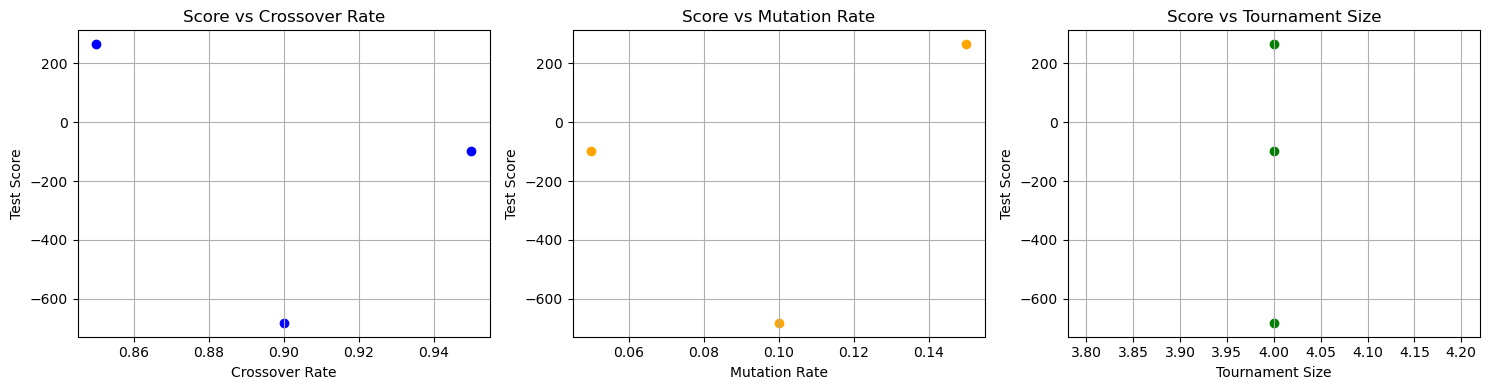

In [18]:
def finetune_variation_selection(configs, repeats=3, early_stop_patience=5):
    results = []

    for cfg in configs:
        all_scores, all_times = [], []

        print(f"\n Testing crossover = {cfg['crossover']}, mutation = {cfg['mutation']}")

        for run in range(repeats):
            start_time = time.time()

            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": cfg["crossover"]}],
                mutations =[{"fun": subtree_mutation, "rate": cfg["mutation"]}]
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            no_improve = 0
            best_fitness = evo.best_of_gens[-1].fitness

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness

                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1

                if early_stop_patience and no_improve >= early_stop_patience:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            all_scores.append(score)
            all_times.append(elapsed)

        avg_score = np.mean(all_scores)
        std_score = np.std(all_scores)
        avg_time = np.mean(all_times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0

        results.append((cfg["crossover"], cfg["mutation"], avg_score, std_score, avg_time, efficiency))
        print(f"Avg Score: {avg_score:.2f} ± {std_score:.2f}, Time: {avg_time:.1f}s, Efficiency: {efficiency:.3f}")

    return results

def save_variation_results_csv(results, folder="log/variation_tuning"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = os.path.join(folder, f"{timestamp}.csv")
    with open(path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Crossover", "Mutation", "Avg Fitness Score", "Std Dev", "Runtime (s)", "Score/sec"])
        writer.writerows(results)
    return timestamp

def plot_variation_tuning(results, folder="log/variation_tuning", timestamp=None):
    crossover, mutation, score, std, runtime, eff = zip(*results)

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    labels = [f"{c:.2f}|{m:.2f}" for c, m in zip(crossover, mutation)]

    axs[0].bar(labels, score, yerr=std, capsize=5, color='skyblue', label="Score ±1 Std")
    axs[0].set_title("Fitness Score vs. Crossover|Mutation")
    axs[0].set_xlabel("Crossover | Mutation Rate")
    axs[0].set_ylabel("Fitness Score")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(labels, eff, marker='s', color='green', label="Score/sec")
    axs[1].set_title("Efficiency vs. Crossover|Mutation")
    axs[1].set_xlabel("Crossover | Mutation Rate")
    axs[1].set_ylabel("Score/sec")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()


configs_variation = [
    {"crossover": 0.9, "mutation": 0.1},
    {"crossover": 0.85, "mutation": 0.15},
    {"crossover": 0.95, "mutation": 0.05},
]
results = finetune_variation_selection(configs_variation, repeats=5, early_stop_patience=5)
timestamp = save_variation_results_csv(results)
plot_variation_tuning(results, timestamp=timestamp)

### Coefficient Optimization

#### Coefficient Mutation Rate

In [3]:
def finetune_coeff_rates(rates, repeats=3, early_stop_patience=5):
    results = []

    for rate in rates:
        coeff_config = [{"fun": coeff_mutation, "rate": rate}]
        scores, times = [], []

        print(f"\n Testing: rate = {rate}")

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": 0.85}],
                mutations=[{"fun": subtree_mutation, "rate": 0.15}],
                coeff_opts=coeff_config,
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= early_stop_patience:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            scores.append(score)
            times.append(elapsed)

        avg_score = np.mean(scores)
        std_score = np.std(scores)
        avg_time = np.mean(times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0
        results.append((rate, avg_score, std_score, avg_time, efficiency))

    return results

def save_coeff_rate_results_csv(results, folder="log/coeff_rate_tuning"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = os.path.join(folder, f"{timestamp}.csv")

    with open(path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Coeff Rate", "Avg Fitness Score", "Std Dev", "Avg Runtime (s)", "Score/sec"])
        writer.writerows(results)

    return timestamp

def plot_coeff_rates(results, folder="log/coeff_rate_tuning", timestamp=None):
    os.makedirs(folder, exist_ok=True)

    rates, scores, stds, times, effs = zip(*results)
    labels = [str(r) for r in rates]

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    axs[0].bar(labels, scores, yerr=stds, capsize=5, color='skyblue', label="Test Score ±1 Std")
    axs[0].set_title("Fitness Score vs. Coeff Mutation Rate")
    axs[0].set_ylabel("Fitness Score")
    axs[0].set_xlabel("Coeff Mutation Rate")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(labels, effs, marker='s', color='seagreen', label="Score/sec")
    axs[1].set_title("Score/sec vs. Coeff Mutation Rate")
    axs[1].set_ylabel("Efficiency (Score/sec)")
    axs[1].set_xlabel("Coeff Mutation Rate")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()

rates = [0.1, 0.3, 0.5, 0.7, 1.0]
results = finetune_coeff_rates(rates, repeats=5, early_stop_patience=5)
timestamp = save_coeff_rate_results_csv(results)
plot_coeff_rates(results, timestamp=timestamp)

#### Range of constant nodes

In [ ]:
def finetune_constant_ranges(ranges, repeats=3, early_stop_patience=5):
    results = []

    for c_range in ranges:
        Constant().range = c_range
        scores, times = [], []

        print(f"\n Testing Constant Range: {c_range}")

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": 0.85}],
                mutations=[{"fun": subtree_mutation, "rate": 0.15}],
                coeff_opts=[{"fun": coeff_mutation, "rate": 0.1}],
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= early_stop_patience:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            scores.append(score)
            times.append(elapsed)

        avg_score = np.mean(scores)
        std_score = np.std(scores)
        avg_time = np.mean(times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0
        results.append((str(c_range), avg_score, std_score, avg_time, efficiency))

    return results

def plot_constant_ranges(results, folder="log/constant_range_tuning", timestamp=None):
    os.makedirs(folder, exist_ok=True)

    ranges, scores, stds, times, effs = zip(*results)

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    axs[0].bar(ranges, scores, yerr=stds, capsize=5, color='skyblue', label="Test Score ±1 Std")
    axs[0].set_title("Fitness Score vs. Constant Range")
    axs[0].set_ylabel("Fitness Score")
    axs[0].set_xlabel("Constant Initialization Range")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(ranges, effs, marker='s', color='seagreen', label="Score/sec")
    axs[1].set_title("Efficiency vs. Constant Range")
    axs[1].set_ylabel("Score/sec")
    axs[1].set_xlabel("Constant Initialization Range")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()

def save_constant_range_results_csv(results, folder="log/constant_range_tuning"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = os.path.join(folder, f"{timestamp}.csv")

    with open(path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Range", "Avg Fitness Score", "Std Dev", "Avg Runtime (s)", "Score/sec"])
        writer.writerows(results)

    return timestamp

ranges = [(-1, 1), (-3, 3), (-5, 5), (-10, 10)]
results = finetune_constant_ranges(ranges, repeats=5, early_stop_patience=5)
timestamp = save_constant_range_results_csv(results)
plot_constant_ranges(results, timestamp=timestamp)

### Internal Node Types 


 Testing internal nodes: Plus+Minus+Times+Div+Log

 Testing internal nodes: Plus+Minus+Times+Div

 Testing internal nodes: Plus+Minus+Times+Div+Sqrt


/home/mkhedr/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Testing internal nodes: Plus+Minus+Times+Div+Sin+Cos

 Testing internal nodes: Plus+Minus+Times+Div+Max+Min

 Testing internal nodes: Plus+Minus+Times+Div+Sin+Cos+Log+Max+Min+Sqrt


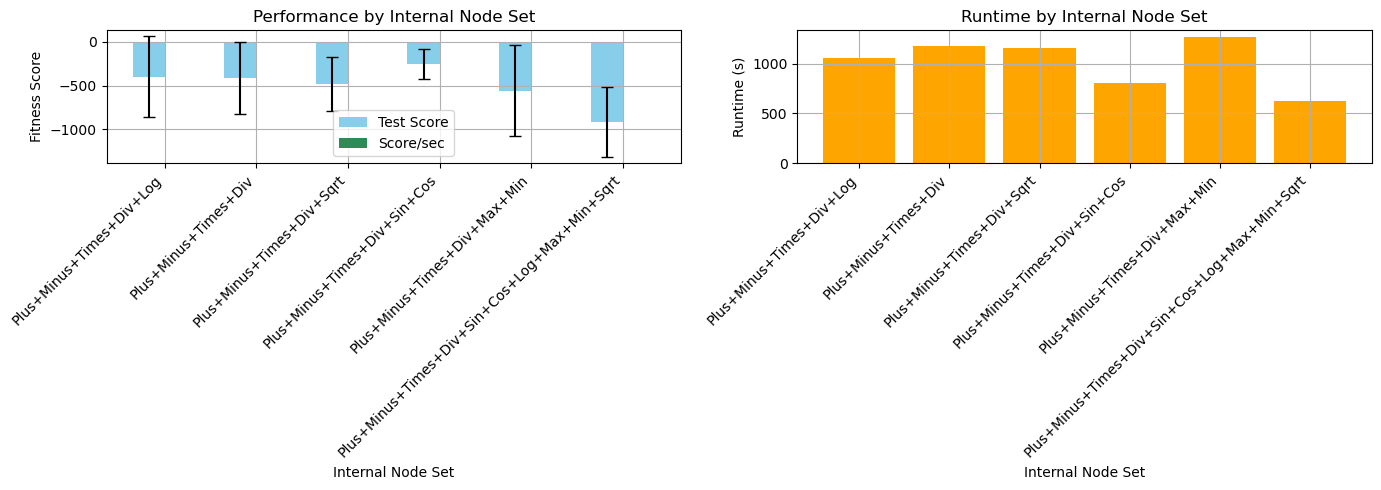

In [21]:
def finetune_internal_nodes(configs, repeats=3, early_stop_patience=5):
    results = []

    for cfg in configs:
        label = '+'.join([node.__class__.__name__ for node in cfg])
        print(f"\n Testing internal nodes: {label}")

        scores, times = [], []

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=cfg,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": 0.85}],
                mutations=[{"fun": subtree_mutation, "rate": 0.15}],
                coeff_opts=[{"fun": coeff_mutation, "rate": 0.1}],
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness

                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1

                if no_improve >= early_stop_patience:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            scores.append(score)
            times.append(elapsed)

        avg_score = np.mean(scores)
        avg_time = np.mean(times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0
        std_score = np.std(scores)
        results.append((label, avg_score, avg_time, efficiency, std_score))

    return results

def save_internal_nodes_csv(results, folder="log/internal_nodes"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = os.path.join(folder, f"{timestamp}.csv")

    with open(path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Internal Nodes", "Fitness Score", "Runtime (s)", "Score/sec", "Std Score"])
        writer.writerows(results)

    return timestamp

def plot_internal_nodes(results, folder="log/internal_nodes", timestamp=None):
    labels, scores, times, effs, std_scores = zip(*results)

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.bar(x - width/2, scores, width, yerr=std_scores, capsize=4, label="Test Score", color='skyblue')
    plt.bar(x + width/2, effs, width, label="Score/sec", color='seagreen')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.title("Performance by Internal Node Set")
    plt.xlabel("Internal Node Set")
    plt.ylabel("Fitness Score")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.bar(x, times, color='orange')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.title("Runtime by Internal Node Set")
    plt.xlabel("Internal Node Set")
    plt.ylabel("Runtime (s)")
    plt.grid(True)

    plt.tight_layout()
    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()


configs = [
    [Plus(), Minus(), Times(), Div(), Log()],
    [Plus(), Minus(), Times(), Div()],
    [Plus(), Minus(), Times(), Div(), Sqrt()],
    [Plus(), Minus(), Times(), Div(), Sin(), Cos()],
    [Plus(), Minus(), Times(), Div(), Max(), Min()],
    [Plus(), Minus(), Times(), Div(), Sin(), Cos(), Log(), Max(), Min(), Sqrt()]
]

results = finetune_internal_nodes(configs, repeats=5, early_stop_patience=5)
timestamp = save_internal_nodes_csv(results)
plot_internal_nodes(results, timestamp=timestamp)

### Constant Probability

In [ ]:
def finetune_constant_prob(probs, repeats=3):
    results = []

    for prob in probs:
        print(f"\n Testing constant probability = {prob}")
        scores, times = [], []

        for _ in range(repeats):
            start_time = time.time()

            Constant.prob = prob  # Make sure your Constant node uses this!

            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": 0.85}],
                mutations =[{"fun": subtree_mutation, "rate": 0.15}],
                coeff_opts=[{"fun": coeff_mutation, "rate": 0.3}],
                selection={"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= 5:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            scores.append(score)
            times.append(elapsed)

        avg_score = np.mean(scores)
        std_score = np.std(scores)
        avg_time = np.mean(times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0
        results.append((prob, avg_score, std_score, avg_time, efficiency))

    return results

def save_constant_prob_results(results, folder="log/const_prob"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    csv_path = os.path.join(folder, f"{timestamp}.csv")
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Constant Prob", "Fitness Score", "Std Dev", "Runtime (s)", "Score/sec"])
        writer.writerows(results)
    return timestamp

def plot_constant_prob(results, folder="log/const_prob", timestamp=None):
    probs, scores, stds, times, effs = zip(*results)
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.bar(probs, scores, yerr=stds, capsize=5, color='skyblue', label="Score ±1 Std")
    plt.title("Fitness Score vs. Constant Probability")
    plt.xlabel("Constant Probability")
    plt.ylabel("Fitness Score")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(probs, times, marker='s', color='orange')
    plt.title("Runtime vs. Constant Probability")
    plt.xlabel("Constant Probability")
    plt.ylabel("Runtime (s)")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(probs, effs, marker='^', color='green')
    plt.title("Score/sec vs. Constant Probability")
    plt.xlabel("Constant Probability")
    plt.ylabel("Score/sec")
    plt.grid(True)

    plt.tight_layout()
    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()

probs = [0.1, 0.25, 0.5, 0.75, 0.9]
results = finetune_constant_prob(probs)
timestamp = save_constant_prob_results(results)
plot_constant_prob(results, timestamp=timestamp)
#

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [ ]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [ ]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

In [ ]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">